# Gesture Recognition part2




In [ ]:
import numpy as np
import os
from imageio import imread
from skimage.transform import resize
import datetime
from collections import deque
import copy

import pandas as pd

import PIL
import cv2
import numpy as np
import pandas as pd  
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.regularizers import l2

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from glob import glob

# hide warnings
import warnings
warnings.filterwarnings('ignore')

# set options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# About Dataset


This dataset has 5 gestures having 30 frames in sequence for each sample.

Each gesture corresponds to the following specific command:

Thumbs up: Increase the volume
Thumbs down: Decrease the volume
Left swipe: 'Jump' backward 10 seconds
Right swipe: 'Jump' forward 10 seconds
Stop: Pause the movie
Each video is a sequence of 30 frames (or images).

The data contains a 'train' and a 'val' folder with two CSV files for the two folders. These folders are in turn divided into subfolders where each subfolder represents a video of a particular gesture. Each subfolder, i.e. a video, contains 30 frames (or images). Note that all images in a particular video subfolder have the same dimensions but different videos may have different dimensions. Specifically, videos have two types of dimensions - either 360x360 or 120x160 (depending on the webcam used to record the videos).

Each row of the CSV file represents one video and contains three main pieces of information - the name of the subfolder containing the 30 images of the video sample (gesture), the name of the gesture, and the numeric label (between 0-4) of the video.

Read the folder names for training and validation. 

In [ ]:
np.random.seed(30)
import random as rn
rn.seed(30)
from tensorflow import keras
import tensorflow as tf
tf.random.set_seed(30)

In [ ]:
!pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/imsparsh/gesture-recognition")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: alyaaselim
Your Kaggle Key: ··········


100%|██████████| 1.60G/1.60G [00:12<00:00, 133MB/s]


In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [ ]:
train_doc = np.random.permutation(open('gesture-recognition/train.csv').readlines())
val_doc = np.random.permutation(open('gesture-recognition/val.csv').readlines())
batch_size = 32
img_size = 100

After lot of analysis and experimentation we found that the ideal batch size, frames_per_video and image size to be used are :<br>
##### batch_size = 32<br>
##### image_size = 100 x 100<br>
##### frames_per_video = 20<br>

In [ ]:
train_doc = np.random.permutation(open('gesture-recognition/train.csv').readlines())
val_doc = np.random.permutation(open('gesture-recognition/val.csv').readlines())

batch_size = 64 #experiment with the batch size
train_doc 

array(['WIN_20180926_17_19_48_Pro_Left_Swipe_new;Left_Swipe_new;0\n',
       'WIN_20180926_17_41_15_Pro_Thumbs_Up_new;Thumbs_Up_new;4\n',
       'WIN_20180926_17_13_39_Pro_Right_Swipe_new;Right_Swipe_new;1\n',
       'WIN_20180926_17_17_07_Pro_Thumbs_Down_new;Thumbs_Down_new;3\n',
       'WIN_20180925_17_46_05_Pro_Stop_new;Stop_new;2\n',
       'WIN_20180907_16_33_33_Pro_Thumbs Down_new;Thumbs Down_new;3\n',
       'WIN_20180925_17_24_49_Pro_Left_Swipe_new;Left_Swipe_new;0\n',
       'WIN_20180907_15_48_25_Pro_Thumbs Down_new;Thumbs Down_new;3\n',
       'WIN_20180925_17_20_55_Pro_Right_Swipe_new;Right_Swipe_new;1\n',
       'WIN_20180907_16_42_19_Pro_Left Swipe_new_Left Swipe_new;Left Swipe_new_Left Swipe_new;0\n',
       'WIN_20180925_17_32_52_Pro_Thumbs_Up_new;Thumbs_Up_new;4\n',
       'WIN_20180926_17_33_51_Pro_Thumbs_Down_new;Thumbs_Down_new;3\n',
       'WIN_20180926_18_05_07_Pro_Right_Swipe_new;Right_Swipe_new;1\n',
       'WIN_20180926_16_57_26_Pro_Left_Swipe_new;Left_Swipe_ne

In [ ]:
if not os.path.exists('data_files'):
    os.mkdir('data_files')
if not os.path.exists('data_files/train'):
    os.mkdir('data_files/train') 
if not os.path.exists('data_files/test'):
    os.mkdir('data_files/test')     

## Create csv file for training data


In [ ]:
root_data_dir = 'gesture-recognition'
# Assigning labels to each flower category
num_classes = 5 
df=pd.read_csv('gesture-recognition/train.csv',sep=';',usecols = [0,2])
labels_name= {row[0] : row[1] for _, row in df.iterrows()}
#test label 
df_test=pd.read_csv('gesture-recognition/val.csv',sep=';',usecols = [0,2])
test_labels_name= {row[0] : row[1] for _, row in df_test.iterrows()}
test_labels_name

{'WIN_20180925_17_43_01_Pro_Left_Swipe_new': 0,
 'WIN_20180925_18_01_40_Pro_Left_Swipe_new': 0,
 'WIN_20180925_18_03_21_Pro_Left_Swipe_new': 0,
 'WIN_20180926_16_46_22_Pro_Left_Swipe_new': 0,
 'WIN_20180926_16_47_09_Pro_Left_Swipe_new': 0,
 'WIN_20180926_17_05_38_Pro_Left_Swipe_new': 0,
 'WIN_20180926_17_08_09_Pro_Left_Swipe_new': 0,
 'WIN_20180926_17_09_33_Pro_Left_Swipe_new': 0,
 'WIN_20180926_17_15_35_Pro_Left_Swipe_new': 0,
 'WIN_20180926_17_21_48_Pro_Left_Swipe_new': 0,
 'WIN_20180926_17_32_55_Pro_Left_Swipe_new': 0,
 'WIN_20180926_17_40_21_Pro_Left_Swipe_new': 0,
 'WIN_20180925_17_25_06_Pro_Right_Swipe_new': 1,
 'WIN_20180925_17_43_46_Pro_Right_Swipe_new': 1,
 'WIN_20180926_16_48_40_Pro_Right_Swipe_new': 1,
 'WIN_20180926_16_52_49_Pro_Right_Swipe_new': 1,
 'WIN_20180926_17_01_52_Pro_Right_Swipe_new': 1,
 'WIN_20180926_17_03_57_Pro_Right_Swipe_new': 1,
 'WIN_20180926_17_12_27_Pro_Right_Swipe_new': 1,
 'WIN_20180926_17_24_12_Pro_Right_Swipe_new': 1,
 'WIN_20180926_17_29_34_Pro_Righ

In [ ]:
# Loop over every activity category in train and test /content/gesture-recognition
train_data_path = os.path.join('/content/gesture-recognition','train')
test_data_path = os.path.join('/content/gesture-recognition','val')
data_dir_list = os.listdir(train_data_path)
data_dir_list

['WIN_20180925_17_08_43_Pro_Left_Swipe_new',
 'WIN_20180925_18_20_19_Pro_Thumbs_Down_new',
 'WIN_20180926_17_39_05_Pro_Stop_new',
 'WIN_20180925_17_55_36_Pro_Right_Swipe_new',
 'WIN_20180907_16_42_55_Pro_Thumbs Up_new',
 'WIN_20180926_17_06_26_Pro_Stop_new',
 'WIN_20180926_17_07_50_Pro_Right_Swipe_new',
 'WIN_20180907_15_44_36_Pro_Right Swipe_new',
 'WIN_20180925_17_29_52_Pro_Left_Swipe_new',
 'WIN_20180925_18_28_41_Pro_Thumbs_Down_new',
 'WIN_20180925_17_49_29_Pro_Left_Swipe_new',
 'WIN_20180907_16_22_23_Pro_Right Swipe_new',
 'WIN_20180925_17_37_17_Pro_Thumbs_Up_new',
 'WIN_20180926_16_56_51_Pro_Thumbs_Up_new',
 'WIN_20180926_17_43_07_Pro_Left_Swipe_new',
 'WIN_20180925_17_47_19_Pro_Right_Swipe_new',
 'WIN_20180925_17_45_31_Pro_Stop_new',
 'WIN_20180907_16_06_35_Pro_Thumbs Down_new',
 'WIN_20180926_16_42_06_Pro_Right_Swipe_new',
 'WIN_20180926_17_19_13_Pro_Stop_new',
 'WIN_20180926_16_58_25_Pro_Stop_new',
 'WIN_20180926_16_35_06_Pro_Thumbs_Down_new',
 'WIN_20180926_17_01_50_Pro_Stop_

In [ ]:
# Loop over every activity category in train and test /content/gesture-recognition
train_data_path = os.path.join('/content/gesture-recognition','train')
test_data_path = os.path.join('/content/gesture-recognition','val')
data_dir_list = os.listdir(train_data_path)
data_dir_list

In [ ]:
  training
video_list = os.listdir(train_data_path)
for vid  in video_list: # looping over gesture-recognition /train and return vedio name  "sub folder in train"
    label = labels_name[str(vid)]
    train_df = pd.DataFrame(columns=['FileName', 'Label', 'ClassName'])
    img_list = os.listdir(os.path.join(train_data_path,vid)) 

    for img in img_list:# looping over every frame within the video
            img_path = os.path.join(train_data_path,vid,img)
            #print(img_path)
            train_df = train_df.append({'FileName': img_path, 'Label': label,'ClassName':vid },ignore_index=True)
    file_name='{}.csv'.format(vid)
    train_df.to_csv('data_files/train/{}'.format(file_name))

In [ ]:
#validation

video_list = os.listdir(test_data_path)
for vid  in video_list: # looping over gesture-recognition /train and return vedio name  "sub folder in test"
    #print(vid)
    label = test_labels_name[str(vid)]
#     print(label)
    test_df= pd.DataFrame(columns=['FileName', 'Label', 'ClassName'])
    img_list = os.listdir(os.path.join(test_data_path,vid)) 

    for img in img_list:# looping over every frame within the video
            img_path = os.path.join(test_data_path,vid,img)
            #print(img_path)
            test_df = test_df.append({'FileName': img_path, 'Label': label,'ClassName':vid },ignore_index=True)
    file_name='{}.csv'.format(vid)
    test_df.to_csv('data_files/test/{}'.format(file_name))

#load_samples


output will be like

sample= [[[data_files\train\WIN_20180907_15_44_32_Pro_Thumbs Down_new\img1,data_files\train\WIN_20180907_15_44_32_Pro_Thumbs Down_new\img2,data_files\train\WIN_20180907_15_44_32_Pro_Thumbs Down_new\img3],label1], [[data_files\train\WIN_20180907_15_44_55_Pro_Stop Gesture_new\img10,data_files\train\WIN_20180907_15_44_55_Pro_Stop Gesture_new\img11,…],label1],……….]
sample [[16frame name],acorrespond label]
then will take this loading sample to feed data_gereation

In [ ]:
# reading the video files from the csv file
# data_files - list of csv files to be read.
#data_path= data_files\train
def file_generator(data_path,data_files,temporal_stride=1,temporal_length=20):
  
   
  # read all the csv files (one csv file corresponds to one vdieo) in data_files one by one
    for file in data_files: #data file folder  have both train and test sub folder
        tmp_df = pd.read_csv(os.path.join(data_path,file)) #ex:data_files\train\any_vedio_name
        label_list = list(tmp_df['Label'])  # Load all the labels in the label_list
        total_images = len(label_list) 
        if total_images>=temporal_length: # only if the number of frames in the video is greater tha temporal length, use that video
            num_samples = int((total_images-temporal_length)/temporal_stride)+1
            print ('num of samples from vid seq-{}: {}'.format(file,num_samples))
            img_list = list(tmp_df['FileName'])
        else: # if the number of frames are less than temporal length , discard it
            print ('num of frames is less than temporal length; hence discarding this file-{}'.format(file))
            continue

        start_frame = 0
        samples = deque() # initliaze a queue to store the frames 
        samp_count=0 # a counter to count the number of smaple. one smaple has as many frames as defined by temporal length
        for img in img_list:
            samples.append(img)
            if len(samples)==temporal_length: #if the queue has as many frames as temporal length, return it as one sample
                samples_c=copy.deepcopy(samples) # copy the queue as in the next stage frames would be popped
                samp_count+=1
                for t in range(temporal_stride): # pop out as many frames as described by the stride from the left to accomodate new frames
                    samples.popleft()
                yield samples_c,label_list[0] # return a sample(consisting of as many frames as defined by temporal length) 
                                                # and its corsponding label

In [ ]:
file_generator('data_files\train','data_files')

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [ ]:
def cropResize(image, y, z):
    h, w = image.shape
    
    # if smaller image crop at center for 120x120
    if w == 160:
        image = image[:120, 20:140]

    # resize every image
    return resize(image, (y,z))

In [ ]:
def normalizeImage(image):
    # applying normalization
    return image/255.0

In [ ]:
def preprocessImage(image, y, z):
    return normalizeImage(cropResize(image, y, z))

In [ ]:
def make3dFilter(x):
    return tuple([x]*3)

def make2dFilter(x):
    return tuple([x]*2)

In [ ]:
def getBatchData(source_path, t, batch, batch_size, img_tensor):
    [x,y,z] = [len(img_tensor[0]),img_tensor[1], img_tensor[2]]
    img_idx = img_tensor[0]
    batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
    batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
    for folder in range(batch_size): # iterate over the batch_size
        imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
        for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
            image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

            #crop the images and resize them. Note that the images are of 2 different shape 
            #and the conv3D will throw error if the inputs in a batch have different shapes

            # separate preprocessImage function is defined for cropping, resizing and normalizing images
            batch_data[folder,idx,:,:,0] = preprocessImage(image[:, :, 0], y, z)
            batch_data[folder,idx,:,:,1] = preprocessImage(image[:, :, 1], y, z)
            batch_data[folder,idx,:,:,2] = preprocessImage(image[:, :, 2], y, z)

        batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
    return batch_data, batch_labels

In [ ]:
def generator(source_path, folder_list, batch_size, img_tensor):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    while True:
        t = np.random.permutation(folder_list)
        num_batches = int(len(folder_list)/batch_size)
        for batch in range(num_batches): # we iterate over the number of batches
            yield getBatchData(source_path, t, batch, batch_size, img_tensor)
        
        # write the code for the remaining data points which are left after full batches
        # checking if any remaining batches are there or not
        if len(folder_list)%batch_size != 0:
            # updated the batch size and yield
            batch_size = len(folder_list)%batch_size
            yield getBatchData(source_path, t, batch, batch_size, img_tensor)

In [ ]:
curr_dt_time = datetime.datetime.now()
train_path = 'gesture-recognition/train'
val_path = 'gesture-recognition/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 10
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 10


In [ ]:
def getImgTensor(n_frames):
    img_idx = np.round(np.linspace(0, 29, n_frames)).astype(int)
    return [img_idx, 100, 100, 3]

# define image tensor size
img_tensor = getImgTensor(20)
print ('# img_tensor =', img_tensor)
print(img_tensor[1])

# img_tensor = [array([ 0,  2,  3,  5,  6,  8,  9, 11, 12, 14, 15, 17, 18, 20, 21, 23, 24,
       26, 27, 29]), 100, 100, 3]
100


In [ ]:
# check complete batch shape
sample_generator = generator(train_path, train_doc, batch_size, img_tensor)
sample_batch_data, sample_batch_labels = next(sample_generator)
print(sample_batch_data.shape) #20 frame in one sample /vedio ,64 sample 
print(sample_batch_labels[1])
# validation batch sample
sample_val_generator = generator(val_path, val_doc, batch_size, img_tensor)
sample_val_batch_data, sample_val_batch_labels = next(sample_val_generator)
print(sample_val_batch_data.shape)

Source path =  gesture-recognition/train ; batch size = 64
(64, 20, 100, 100, 3)
[1. 0. 0. 0. 0.]
Source path =  gesture-recognition/val ; batch size = 64
(64, 20, 100, 100, 3)


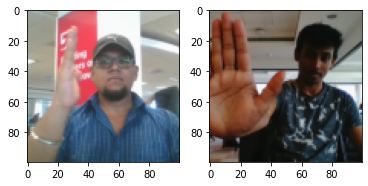

In [ ]:
# visulaize  sample images
fig, ax = plt.subplots(1,2)
ax[0].imshow(sample_val_batch_data[24,19,:,:,:])   
ax[1].imshow(sample_val_batch_data[42,10,:,:,:])
plt.show()

#### A utility function to plot the accuracy - loss graph after fitting the various models to analyze and compare their performance 

In [ ]:
def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

#### Checking the size of train and validation dataset

In [ ]:
curr_dt_time = datetime.datetime.now()
train_path = '/kaggle/input/gesturerecognitiondataset/Project_data/train'
val_path = '/kaggle/input/gesturerecognitiondataset/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 30
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 30


## Model Building
Here we make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [ ]:
# importing specific libraries for model building
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU,LSTM, TimeDistributed,Dropout, Flatten
from tensorflow.keras.layers import BatchNormalization, Activation, Conv3D, MaxPooling3D, Conv2D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers
from tensorflow.keras.applications import densenet

# number of classes are 5, as we know that number of gestures to be recognized are 5 in number
num_classes = 5

In [ ]:
model = Sequential([
    # 1st conv layer
  layers.Conv3D(64, kernel_size=(3, 3, 3), activation='relu', padding='same', input_shape=(20,img_size,img_size,3)),
  layers.MaxPooling3D(pool_size=(2, 2, 2)),
  layers.Dropout(0.25),
    
    #2nd conv layer
  layers.Conv3D(128, kernel_size=(3, 3, 3), padding='same', activation='relu'),
  layers.MaxPooling3D(pool_size=(2, 2, 2)),
  layers.Dropout(0.25),
  
    #3rd conv layer
  layers.Conv3D(256, kernel_size=(3, 3, 3), padding='same', activation='relu'),
  layers.MaxPooling3D(pool_size=(2, 2, 2)),
  layers.Dropout(0.25),
    
    # flatten
  layers.Flatten(),
    # 1st dense layer
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.25),
    # output layer with softmax
  layers.Dense(num_classes,activation='softmax')
])

#### Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [ ]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [ ]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto',period = 1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, verbose=1, patience=2,mode='min', epsilon=0.0001, cooldown=0, min_lr=0.00001)
callbacks_list = [LR]

#### The `steps_per_epoch` and `validation_steps` are used by `fit` method to decide the number of next() calls it need to make.

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
# running model fit with 10 epochs for experimental model
num_epochs = 10
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /kaggle/input/gesturerecognitiondataset/Project_data/train ; batch size = 32


2021-10-15 06:50:23.367366: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2021-10-15 06:50:25.197912: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


21/21 [==============================] - 244s 12s/step - loss: 1.6206 - categorical_accuracy: 0.1946 - val_loss: 1.5986 - val_categorical_accuracy: 0.2500
Epoch 2/10
21/21 [==============================] - 225s 11s/step - loss: 1.5968 - categorical_accuracy: 0.2398 - val_loss: 1.5938 - val_categorical_accuracy: 0.3200
Epoch 3/10
21/21 [==============================] - 199s 10s/step - loss: 1.5770 - categorical_accuracy: 0.2640 - val_loss: 1.5840 - val_categorical_accuracy: 0.2300
Epoch 4/10
21/21 [==============================] - 194s 10s/step - loss: 1.5671 - categorical_accuracy: 0.2579 - val_loss: 1.5761 - val_categorical_accuracy: 0.2400
Epoch 5/10
21/21 [==============================] - 198s 10s/step - loss: 1.5400 - categorical_accuracy: 0.3107 - val_loss: 1.5583 - val_categorical_accuracy: 0.3400
Epoch 6/10
21/21 [==============================] - 199s 10s/step - loss: 1.5403 - categorical_accuracy: 0.3137 - val_loss: 1.5389 - val_categorical_accuracy: 0.4700
Epoch 7/10
21/2

### Plot graph

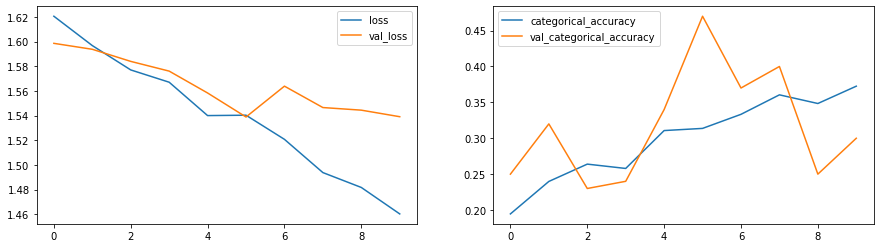

In [ ]:
#lets plot the model performance graph
plot(history)

#### Looking at the above graph we see that both train loss and val loss decreases, but the val categorical accuracy is jumpy and is not reliable

### second model Conv2D + LSTM model 

Now we are buiding the model using Conv2D and then usinf LSTM layers to do the model fit,
This is a CNN + LSTM model

### Model 3

In [ ]:
model = Sequential()

# 1st CNN layer
model.add(TimeDistributed(Conv2D(32, (3,3),activation='elu'),input_shape=(20,img_size,img_size,3)))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

# 2nd CNN layer
model.add(TimeDistributed(Conv2D(64, (3, 3), activation='elu')))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

# 3rd CNN Layer
model.add(TimeDistributed(Conv2D(128, (3,3), activation='elu')))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

# 4th CNN Layer
model.add(TimeDistributed(Conv2D(256, (3,3),activation='elu')))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

# 5th CNN Layer
model.add(TimeDistributed(Conv2D(256, (3,3),activation='elu')))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

# Flatten
model.add(TimeDistributed(Flatten()))

# 2 LSTM layers with tanh activation
model.add(LSTM(128,activation='tanh', return_sequences=True))
model.add(LSTM(128,activation='tanh', return_sequences=False))
model.add(Dropout(0.25))

# Dense layer
model.add(Dense(128, activation='elu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

# output layer with softmax
model.add(Dense(num_classes,activation='softmax'))

In [ ]:
#optimiser = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.7, nesterov=True)
optimiser = optimizers.Adam(lr=0.001)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 20, 98, 98, 32)    896       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 20, 49, 49, 32)    0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 20, 47, 47, 64)    18496     
_________________________________________________________________
time_distributed_3 (TimeDist (None, 20, 23, 23, 64)    0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 20, 21, 21, 128)   73856     
_________________________________________________________________
time_distributed_5 (TimeDist (None, 20, 10, 10, 128)   0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, 20, 8, 8, 256)    

In [ ]:
# Epochs 30
num_epochs=30
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/30
21/21 [==============================] - 203s 10s/step - loss: 2.0966 - categorical_accuracy: 0.2624 - val_loss: 1.7743 - val_categorical_accuracy: 0.2100
Epoch 2/30
21/21 [==============================] - 204s 10s/step - loss: 1.9437 - categorical_accuracy: 0.2775 - val_loss: 1.7409 - val_categorical_accuracy: 0.2300
Epoch 3/30
21/21 [==============================] - 197s 10s/step - loss: 1.6894 - categorical_accuracy: 0.3183 - val_loss: 1.4966 - val_categorical_accuracy: 0.4100
Epoch 4/30
21/21 [==============================] - 191s 10s/step - loss: 1.6095 - categorical_accuracy: 0.3575 - val_loss: 1.7744 - val_categorical_accuracy: 0.2500
Epoch 5/30
21/21 [==============================] - 200s 10s/step - loss: 1.5111 - categorical_accuracy: 0.3575 - val_loss: 1.5923 - val_categorical_accuracy: 0.2400

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 6/30
21/21 [==============================] - 211s 11s/step - loss: 1.3463 - catego

####  Analysing the above model fit hisory the best model checkpoint is : <br>

Epoch 26/30
21/21 [==============================] - 202s 10s/step - loss: 0.2392 - categorical_accuracy: 0.9095 - val_loss: 0.8297 - val_categorical_accuracy: 0.7400


#### this is somewhat decent but not as good as the previous Conv3D model

### Plot graph

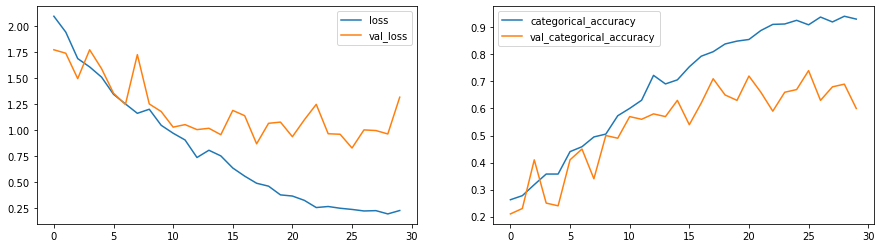

In [ ]:
# Lets plot the performance graph
plot(history)

#### Analyzing the graph both val loss and val categorical accuracy show a bit of overfitting

### Transfer Learning using DenseNet169

Here we use the concept of Transfer learning and use a pretrained model and then use a GRU layer for final training.
Among the models available in the Keras API (Keras Applications) such as VGG, ResNet, DenseNet, InceptionV3 and MobileNet.
DenseNet-169 was chosen because despite having a depth of 169 layers it is relatively low in parameters compared to other models, and the architecture handles the vanish gradient problem well

### Model 4

In [ ]:
densenet = keras.applications.DenseNet169(include_top=False, input_shape=(img_size, img_size, 3), weights='imagenet')
trainable = 5
for layer in densenet.layers[:-trainable]:
     layer.trainable = False
for layer in densenet.layers[-trainable:]:
    layer.trainable = True

51888128/51877672 [==============================] - 0s 0us/step


In [ ]:
model = Sequential()

# densenet layer
model.add(TimeDistributed(densenet,input_shape=(20,img_size,img_size,3)))

# Flatten
model.add(TimeDistributed(Flatten()))

# GRU Layer
model.add(GRU(128))
model.add(Dropout(0.25))

# Dense layer
model.add(Dense(128, activation='elu'))
model.add(Dropout(.25))

# final output layer with softmax
model.add(Dense(num_classes,activation='softmax'))

In [ ]:
#optimiser = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.7, nesterov=True)
optimiser = optimizers.Adam(lr=0.001)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_11 (TimeDis (None, 20, 3, 3, 1664)    12642880  
_________________________________________________________________
time_distributed_12 (TimeDis (None, 20, 14976)         0         
_________________________________________________________________
gru (GRU)                    (None, 128)               5800704   
_________________________________________________________________
dropout_16 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_17 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 5)                

In [ ]:
# Epocchs 30
num_epochs = 30
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/30
21/21 [==============================] - 215s 10s/step - loss: 1.7306 - categorical_accuracy: 0.3288 - val_loss: 1.3161 - val_categorical_accuracy: 0.5200
Epoch 2/30
21/21 [==============================] - 196s 10s/step - loss: 1.1724 - categorical_accuracy: 0.5204 - val_loss: 0.9711 - val_categorical_accuracy: 0.5600
Epoch 3/30
21/21 [==============================] - 202s 10s/step - loss: 0.9746 - categorical_accuracy: 0.6154 - val_loss: 0.9405 - val_categorical_accuracy: 0.5900
Epoch 4/30
21/21 [==============================] - 201s 10s/step - loss: 0.7524 - categorical_accuracy: 0.6983 - val_loss: 0.8756 - val_categorical_accuracy: 0.6700
Epoch 5/30
21/21 [==============================] - 207s 10s/step - loss: 0.5890 - categorical_accuracy: 0.7949 - val_loss: 0.7682 - val_categorical_accuracy: 0.7200
Epoch 6/30
21/21 [==============================] - 201s 10s/step - loss: 0.5487 - categorical_accuracy: 0.7979 - val_loss: 0.6624 - val_categorical_accuracy: 0.7500
Epoc

#### Looking at the model fit history above the best model checkpoint thus obtained is : <br>

Epoch 00023: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
Epoch 24/30
21/21 [==============================] - 206s 10s/step - loss: 0.0399 - categorical_accuracy: 0.9955 - val_loss: 0.3262 - val_categorical_accuracy: 0.8800



### Plot graph

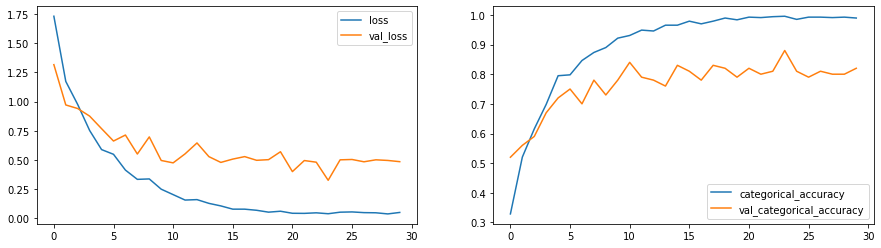

In [ ]:
# Lets plot the performance graph
plot(history)

#### Analysing the graphs above both loss abd categorical accuracy is quite decent.

+ train loss : 0.39% <br>
+ train categorical accuracy : 99% <br>
+ val loss : 3.2% <br>
+ val categorical accuracy: 88%